In [1]:
import os
import torch
import numpy as np

#torch.backends.cudnn.enabled = True
#torch.backends.cudnn.benchmark = False
vis = False
save_output = True

In [2]:
%run network.ipynb

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [3]:
%run data_loader.ipynb

In [4]:
%run utils.ipynb

In [5]:
import torch.nn as nn

class CrowdCounter(nn.Module):
    def __init__(self):
        super(CrowdCounter, self).__init__()        
        self.DME = MCNN()        
        self.loss_fn = nn.MSELoss()
        
    @property
    def loss(self):
        return self.loss_mse
    
    def forward(self,  im_data, gt_data=None):  
        im_data = np_to_variable(im_data, is_cuda=True, is_training=self.training)  
        density_map = self.DME(im_data)
        
        if self.training:                        
            gt_data = np_to_variable(gt_data, is_cuda=True, is_training=self.training)            
            self.loss_mse = self.build_loss(density_map, gt_data)
            
        return density_map
    
    def build_loss(self, density_map, gt_data):
        loss = self.loss_fn(density_map, gt_data)
        return loss

In [6]:
output_dir = '../output_test/'
train_path = '../ShanghaiTech/ShanghaiTech/part_B/test_data/images/'
train_gt_path = '../ShanghaiTech/ShanghaiTech/part_B/train_data/ground-truth-h5/'
model_path = '../saved_models/MCNN_shtechA_106.h5'
test_path = '../ShanghaiTech/ShanghaiTech/part_B/test_data/images/IMG_282.jpg'
test_path_gt = '../ShanghaiTech/ShanghaiTech/part_B/test_data/ground-truth/GT_IMG_282.mat'
test_path_protest = '../test_data/strajk.jpg'

image_paths = os.listdir(train_path)

for i in range(len(image_paths)):
    image_paths[i] = train_path + image_paths[i]

target_paths = os.listdir(train_gt_path)

for i in range(len(target_paths)):
    target_paths[i] = train_gt_path + target_paths[i]

In [7]:
trainset = MyDataset(image_paths, target_paths)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle=False, num_workers=0)

data_loader = iter(trainloader)

In [8]:
model_name = os.path.basename(model_path).split('.')[0]
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

net = CrowdCounter()
      
trained_model = os.path.join(model_path)
load_net(trained_model, net)
net.cuda()
net.eval()
mae = 0.0
mse = 0.0

im_data = (Image.open(test_path)).convert('L')
im_data = im_data.resize((256, 256))
im_data = np.array(im_data)
im_data = np.expand_dims(im_data, 0) 
im_data = np.expand_dims(im_data, 1) 
density_map = net(im_data)
density_map = density_map.data.cpu().numpy()
et_count = np.sum(density_map)
print(et_count)
#mae += abs(gt_count-et_count)
#mse += ((gt_count-et_count)*(gt_count-et_count))
if vis:
    input_img = im_data[0][0]
    density_map = 255*density_map/np.max(density_map)
    density_map= density_map[0][0]
    if density_map.shape[1] != input_img.shape[1]:
         input_img = cv2.resize(input_img, (density_map.shape[1],density_map.shape[0]))
    result_img = np.hstack((input_img,density_map))
    result_img  = result_img.astype(np.uint8, copy=False)
    cv2.imshow('Result', result_img)
    cv2.waitKey(0)
if save_output:
    save_density_map(density_map, output_dir, 'output_' + '1od5' + '.png')
        
mae = mae/len(data_loader)
mse = np.sqrt(mse/len(data_loader))
print('\nMAE: %0.2f, MSE: %0.2f' % (mae,mse))



12.3170805

MAE: 0.00, MSE: 0.00


In [9]:
import scipy.io

mat = scipy.io.loadmat(test_path_gt)
print(mat['image_info'][0][0][0][0][1])

[[24]]


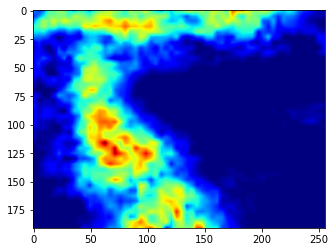

In [10]:
import cv2
from matplotlib.pyplot import imshow
from matplotlib.image import imread
from matplotlib import cm as c

im = imread('../output_test/output_1od5.png')
imshow(im, cmap=c.jet)


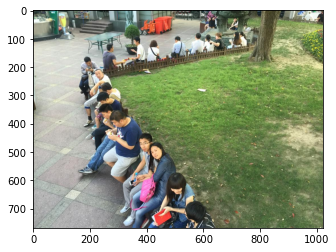

In [11]:
im = imread(test_path)
imshow(im)